## Seminar 5: Generalization and Function Approximation

In this seminar, we will practice solving reinforcement problems by using function approximation. Specifically, we will consider the following exercise: 
* The Mountain Car example: linear function approximator

Assumed that you have already installed Numpy and Scipy, install sklearn using pip
```
pip install -U scikit-learn
```

In [1]:
import gym
import sklearn.pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Before starting looking into our exercises, we provie a summary of some basic concepts.

## A quick summary of some basic concepts

### On-policy vs off-policy methods

On-policy methods aim to estimate the value of the policy that is used for control. Examples of on-policy methods are:  
- On-policy MC control 
- On-policy TD control: SARSA

The updates of action estimates according to SARSA are of the following form:

$$
Q(s_t,a_t){\leftarrow}Q(s_t,a_t)+\alpha[r_{t+1}+{\gamma}Q(s_{t+1},a_{t+1})-Q(s_t,a_t)]
$$

An on-policy method updates action value estimates using the values of next state-action pairs where **the next actions are generated by the current policy**. 

In off-policy methods, the behaviour policy that generates actions may be unrelated to the action that is being used in the target. Examples of off-policy methods include: 

- Off-policy TD control: Q-learning

The updates of action estimates according to Q-learning are of the following form:

$$
Q(s_t,a_t){\leftarrow}Q(s_t,a_t)+\alpha[r_{t+1}+{\gamma}\max_{a}Q(s_{t+1},a)-Q(s_t,a_t)]
$$

Q-learning updates action value estimates using the values of next state-action pairs where **the next actions are generated by a greedy policy**.   That is to say,  the action-state values are estimated under the assumption of a greedy policy despite the fact that it is not following a greedy policy. 

### Online vs offline methods

In general, online learning is learning as new data becomes available. 
An update of state/state-action value is made after each action is taken and a new observation is obtained. 
Many online learning methods can also be made offline. 
The following classifications are based on the version of algorithms taught in this course: 
- TD(0)
- Sarsa
- Q-learning

Off-line learning means learning from a static dataset. 
In our case, learning is done by the end of an entire episode using data collected during the episode. Examples are:
- MC methods
- n-Step TD
- TD($\lambda$)

### Recap on value function approximation

What you have learned in the lecture: 

<img  src="./graphs/linear_function_approximation_1.png"  width="750"/>
<img  src="./graphs/linear_function_approximation_2.png"  width="750"/>

## The Mountain Car Problem 
The Mountain Car problem is described in **Example 10.1** (2nd Edition) in Sutton & Barto. 
The basic idea is driving the car to reach the goal position by building up momentum. 
We will use the existing environment in OpenAI Gym (ID: MountainCar-v0).

- Actions = [push left (0), no push (1), push right (2)]
- Reward is -1 on all time steps until the car reaches its goal
- The state space is continuous
- The states have two dimensions: state = [position, velocity]
- Position: [-1.2, 0.6]
- The goal is to reach the flag position(0.5)
- Velocity: [-0.7, 0.7]

In [2]:
from IPython.display import Video
Video('./graphs/mountain_car.mp4')

### Feature engineering 
There are many ways to create the feature vector of a state. We can either use handcrafted or learned features. For instance, AlphaGo uses handcrafted features:

<img  src="./graphs/alpha_go_features.png" width="650"/>

In reinforcement learning, the commonly used methods to extract features include tile-coding, kernel functions, or neural networks. 
In this exercise, we will create the feature vectors using kernel methods. 

The RBF kernel is defined as 
$$
K(x,x')=\exp(-\gamma\|x-x'\|^2)
$$

For any positive definite kernel $K(x,x')$ in recursive Kernel Hilbert space (RKHS), we have
$K(x,x')=\phi(x)^{\top}{\phi(x')}$, where $\phi$
is a feature map.

#### Normalize data
As the RBF kernel assumes all features are centred around 0 and have variance in the same order, we will normalize 
the data as the first step. For the task of normalization and feature engineering, we will use the **scikit-learn** library.

As this method falls into the category of online learning, we will define a normalizer and feature extractor using 
some pre-training data as follows:

We randomly sample 10000 observations as pre-training data for normalization.

In [3]:
openai_env = 'MountainCar-v0'# env = gym.envs.make('CartPole-v1')
env = gym.make(openai_env, render_mode="rgb_array")
n_actions = env.action_space.n
actions = np.arange(n_actions)
sample_size = 10000

#Note: Alternatively create samples via env.observation_space.sample()

obs_samples = []
num_samples = 0
while num_samples < sample_size:
    env.reset()
    done = False
    while not done:
        observation, _, done, _, _, = env.step(env.action_space.sample())
        obs_samples.append(observation)
        num_samples += 1
# obs_samples = np.array([env.observation_space.sample() for i in range(sample_size)])
# print(obs_samples)

The following code creates an instance of the sklearn StandardScaler class which has a method `.fit()`that computes the mean and standard deviation to be used for later scaling.



In [4]:
# scaler = sklearn.preprocessing.StandardScaler().fit(obs_samples)

When a new observation comes in, we can simply call 



In [5]:
# scaled_state = scaler.transform([state])

to normalize the latest observed state.  

#### Create features 
The `sklearn.pipeline.FeatureUnion` class concatenates results of multiple transformer objects. This class allows you to combine 
multiple feature extraction mechanisms into a single transformer. We will choose 4 RBF kernels with different gamma values and an 
output dimensionality of 100. Each RBF kernel gives a 100-dimensional random feature vector that can be used to approximate the feature map function. The larger the dimension, the more accurate it approximates the true feature vector. Alternatively, we can select gamma using the median heuristic (see e.g., https://arxiv.org/abs/1707.07269)

```
feature_dim = 100

featuriser = sklearn.pipeline.FeatureUnion(
[("rbf1", RBFSampler(gamma=5.0, n_components=feature_dim)),
("rbf2", RBFSampler(gamma=2.0, n_components=feature_dim)),
("rbf3", RBFSampler(gamma=1.0, n_components=feature_dim)),
("rbf4", RBFSampler(gamma=0.5, n_components=feature_dim))])
```

We now fit all the transformers using the scaled samples by the method `.fit()` under this class,

```
featuriser.fit(scaler.transform(obs_samples))
```

The `.transform()` method of the `scaler` returns the centred and scaled samples.
```
features = featuriser.transform(scaled)
```

Now the `scaler` and `featuriser` are ready for later use.  When we obtain a new state, we can transform it to feature vectors easily.



### Control with function approximation

We approximate the action-value function by a linear combination of features, i.e.,

$$\hat{Q}(s,a,\mathbf{w})=\phi(s,a)^{\top}\mathbf{w}$$


The objective function is the MSE between the true action value $Q(s,a)$ and 
$\hat{Q}(s,a,\mathbf{w})$:

$$
\mathcal{L(\mathbf{w})}=\frac{1}{2}\mathbb{E}_{s,a,r,s'}[(Q(s,a)-\hat{Q}(s,a,\mathbf{w}))^2]
$$

  
Differentiating the objective w.r.t. the parameter $\mathbf{w}$, we obtain the parameter update

$$
\mathbf{w}_{t+1}=\mathbf{w}_t+{\eta}(Q(s_t,a_t)-\hat{Q}(s_t,a_t,\mathbf{w}_t))\phi(s_t,a_t)
$$

Unfortunately, we don't have access to the true $Q(s,a)$ in practice. We therefore substitute a target for it.

We can substituting with a SARSA target

$$Q(s_t,a_t)=r_{t}+\gamma\hat{Q}(s_{t+1},a_{t+1},\mathbf{w}_t)$$

or a Q-learning target,

$$
Q(s_t,a_t)=r_{t}+\gamma\max_{a'}\hat{Q}(s_{t+1},a',\mathbf{w}_t)
$$

In the following implementation, we choose the SARSA target as a substitution to the true state-action values. The update for parameter $\mathbf{w}$ is therefore 

$$
\mathbf{w}_{t+1}=\mathbf{w}_t+{\eta}(r_{t}+\gamma\hat{Q}(s_{t+1},a_{t+1},\mathbf{w}_t)-\hat{Q}(s_t,a_t,\mathbf{w}_t))\phi(s_t,a_t)
$$

#### Implementation of the approximation function

In [6]:
class Approximator:
    def __init__(self, obs, dim, n_a, alpha, discount):
        self.__discount = discount
        self.__alpha = alpha
        self.__n_actions = n_a
        self.__obs_samples = obs
        self.__feature_dim = dim
        self.__w_size = 4 * self.__feature_dim
        self.__w = np.zeros((self.__n_actions, self.__w_size))
        self.__scaler = None
        self.__featuriser = None
        self.__initialised = False

    def initialise_scaler_featuriser(self):
        self.__scaler = sklearn.preprocessing.StandardScaler().fit(self.__obs_samples)
        self.__featuriser = sklearn.pipeline.FeatureUnion(
                [("rbf1", RBFSampler(gamma=5.0, n_components=self.__feature_dim)),
                 ("rbf2", RBFSampler(gamma=2.0, n_components=self.__feature_dim)),
                 ("rbf3", RBFSampler(gamma=1.0, n_components=self.__feature_dim)),
                 ("rbf4", RBFSampler(gamma=0.5, n_components=self.__feature_dim))])
        self.__featuriser.fit(self.__scaler.transform(self.__obs_samples))
        self.__initialised = True

    @property
    def get_w(self):
        return self.__w

    def feature_transformation(self, state):
        if not self.__initialised:
            self.initialise_scaler_featuriser()

        scaled = self.__scaler.transform([state])
        features = self.__featuriser.transform(scaled)
        return features

    # linear_features
    def action_value_estimator(self, features, a):
        return np.inner(features, self.__w[a])

    # minimising MSE between q(replaced by td target) and q_hat
    def update_w(self, r, q, next_q, features, a):
        target = r + self.__discount * next_q
        td_error = target - q
        w_gradient = self.__alpha * td_error * features
        self.__w[a] = self.__w[a] + w_gradient
        
    def set_w(self, a, new_w):
        self.__w[a] = new_w

    def cost_to_go(self, state):
        features = self.feature_transformation(state)
        v_s = []
        for i in range(self.__n_actions):
            v_s.append(self.action_value_estimator(features, i))
        return - np.max(v_s)


The cost to go function is defined as $f=-\max_{a}Q_t(s,a)$

In [7]:
def plot_v(estimator, i=None):
    if openai_env == 'MountainCar-v0':
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(projection='3d')

        x = np.linspace(-1.2, 0.6, 30)
        y = np.linspace(-0.07, 0.07, 30)

        X, Y = np.meshgrid(x, y)
        states = np.dstack((X, Y))

        values = np.apply_along_axis(estimator.cost_to_go, 2, states)

        ax.plot_surface(X, Y, values, cmap=plt.cm.coolwarm, linewidth=1, rstride=1, cstride=1)

        extra_title = ""
        if i:
            extra_title = " after {} iterations".format(i)
        ax.set_title("Cost to go function" + extra_title)
        ax.set_xlabel("Position")
        ax.set_ylabel("Velocity")
        ax.set_zlabel("Value")
        plt.show()

#### Solve the problem
Based on the randomly-sampled 10000 observations, create an instance of the state-action function approximator and initialize the normaliser and feature extractor: 

In [8]:
alpha = 0.1
gamma = 1.0
epsilon = 0.1
dim = 100

# create an instance of approximator and initialize the normalizer and feature extractor 
estimator = Approximator(obs_samples, dim, n_actions, alpha, gamma)  
estimator.initialise_scaler_featuriser() 

Play the game and do online updates for parameter $\mathbf{w}$,

In [9]:
def epsilon_greedy_policy(epsilon, actions, values):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(values) if value_ == np.max(values)])

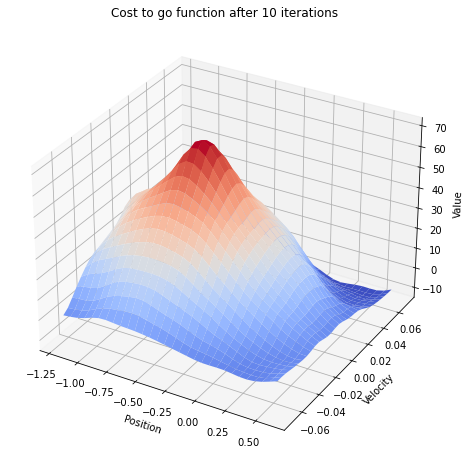

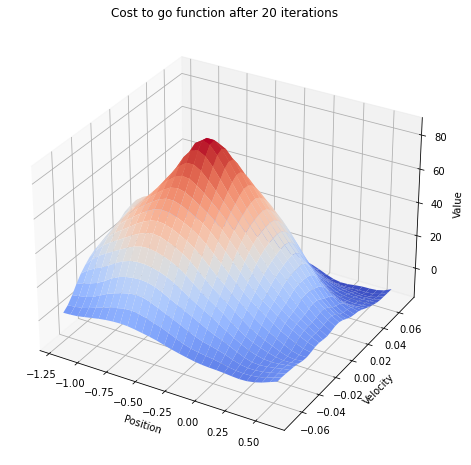

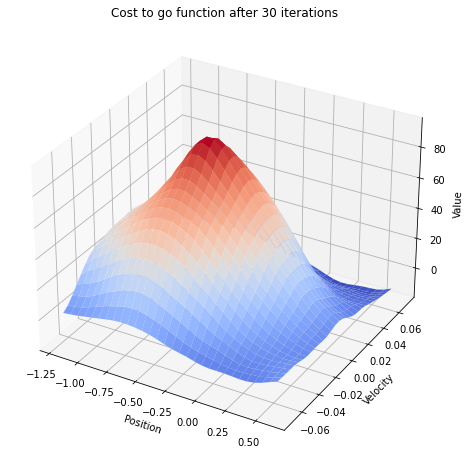

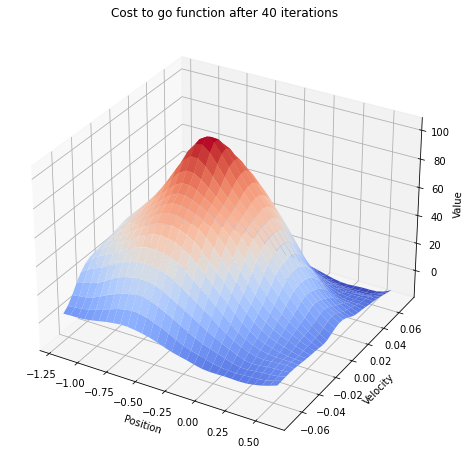

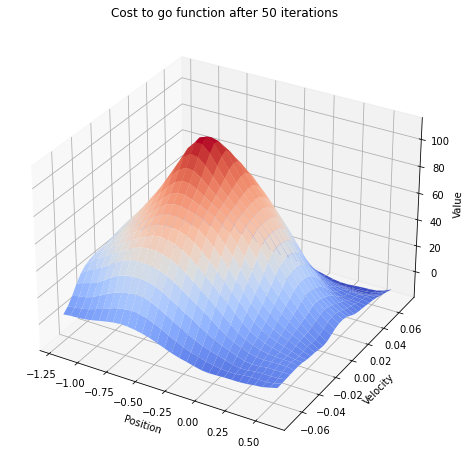

In [10]:
episodes = 50
for i in range(1, episodes + 1):
    state = env.reset()[0]
    a = env.action_space.sample()
    step_count = 0
    while True:
        step_count +=1 
        next_state, r, done, _, _, = env.step(a)  # check the openAI github repo

        if done:
            break

        # compute q_sa
        features = estimator.feature_transformation(state)
        q_sa = estimator.action_value_estimator(features, a)

        # compute all actions in the next state for optimal policy
        next_feature = estimator.feature_transformation(next_state)
        q_values = []
        for j in actions:
            q_values.append(estimator.action_value_estimator(next_feature, j))

        next_a = epsilon_greedy_policy(epsilon, actions, q_values)
        next_q_sa = estimator.action_value_estimator(next_feature, next_a)

        # update weights for current action
        estimator.update_w(r, q_sa, next_q_sa, features, a)

        a = next_a
        state = next_state
    if i % 10 == 0:
        plot_v(estimator, i)

### Results


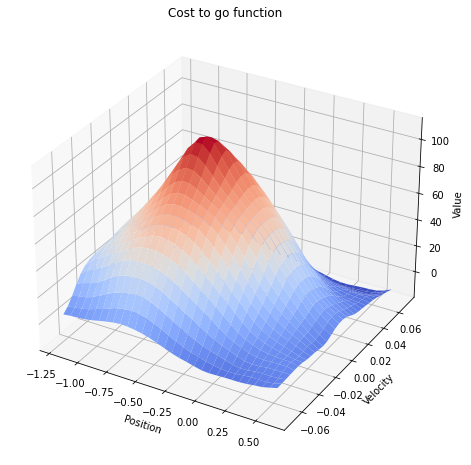

In [11]:
plot_v(estimator)

-156.0


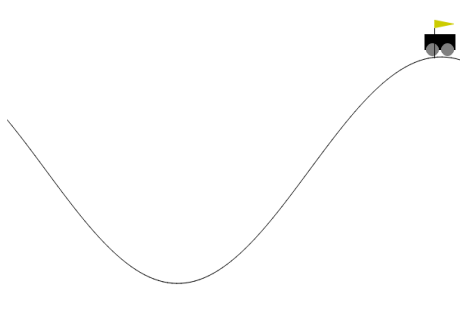

In [12]:
import matplotlib.animation
import matplotlib
from IPython.display import HTML

rewards = 0
env.reset()
frames = []
action = env.action_space.sample()
while True:
    s, r, done, _, _, = env.step(action)
    frames.append(env.render())
    rewards = rewards + r
    if done:
        break

    feature = estimator.feature_transformation(s)
    q_values = []
    for j in actions:
        q_values.append(estimator.action_value_estimator(feature, j))

    action = epsilon_greedy_policy(0, actions, q_values)
print(rewards)

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

## Precomputed graphs

The first plot is after 4 episodes, whilst the second one is after 100 episodes

<img  src="./graphs/mountain_car4epi.png"  width="550"/>  <img  src="./graphs/mountain_car.png"  width="550"/>

As we will see, the optimal policy after 4 episodes of training is not good enough to solve the task.

In [13]:
Video('./graphs/4episodes.mp4')

Policy after 100 episodes

In [14]:
Video('./graphs/100episodes.mp4')

To replicate the results in the Sutton & Barto book, we observe that the action-values indeed display a spiral shape.

The left plot is after 1000 episodes, whilst the right one is after 9000 episodes,

<img  src="./graphs/mountain_car1000epi.png"  width="550"/>  <img  src="./graphs/mountain_car9000epi.png"  width="550"/>